---
title: DANL-210 Project
author: Jacob Miller
date: 2025-05-16
categories: [python, data organization, data manipulation] # tags for a blog post (e.g., python)
image: "____.png"

toc: true
---


# Background
In recent years, the importance of Environmental, Social, and Governance (ESG) performance has grown significantly among investors and regulatory bodies. ESG metrics are now seen as essential indicators of a company's long-term stability, ethical conduct, and risk exposure.
Despite this shift, traditional financial indicators such as revenue growth, profit margins, and stock performance continue to drive investment decisions. Gaining insight into how ESG risk scores change over time and how they correlate with financial outcomes can help companies align sustainable practices with long-term value creation.

# Introduction

This project explores the relationship between a companys ESG risk score and its financial performance. By integrating ESG data with key financial indicators, the goal is to uncover trends that may support more responsible, sustainability-oriented investment decisions.






# Data Collection
 Python selenium web-scraping of Yahoo Finance data

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# Load saved CSVs
url_2024 = "https://bcdanl.github.io/data/esg_proj_2024_data.csv"
esg_proj_2024_data = pd.read_csv(url_2024)
url = "https://bcdanl.github.io/data/stock_history_2023.csv"
stock_history_2023 = pd.read_csv(url)

print(esg_proj_2024_data)
print(stock_history_2023)

# Compute daily returns
stock_history_2023['Return'] = stock_history_2023['Close'].pct_change()

# Quick peek at data types
print(esg_proj_2024_data.dtypes)
print(stock_history_2023.dtypes)

# Drop rows missing key ESG values
esg_proj_2024_data = esg_proj_2024_data.dropna(subset=['Total_ESG'])

# Aggregate
avg_esg    = esg_proj_2024_data.groupby('Symbol')['Total_ESG'].mean().reset_index()
avg_return = stock_history_2023.groupby('Symbol')['Return'].mean().reset_index()
company_df = pd.merge(avg_esg, avg_return, on='Symbol')

     Year Symbol                                       Name  \
0    2024      A     Agilent Technologies Inc. Common Stock   
1    2024     AA            Alcoa Corporation Common Stock    
2    2024    AAL  American Airlines Group Inc. Common Stock   
3    2024    AAP                    Advance Auto Parts Inc.   
4    2024   AAPL                    Apple Inc. Common Stock   
..    ...    ...                                        ...   
620  2024    XYL                Xylem Inc. Common Stock New   
621  2024    YUM                           Yum! Brands Inc.   
622  2024      Z    Zillow Group Inc. Class C Capital Stock   
623  2024    ZBH   Zimmer Biomet Holdings Inc. Common Stock   
624  2024    ZTS           Zoetis Inc. Class A Common Stock   

                     Sector                                          Industry  \
0               Industrials  Biotechnology: Laboratory Analytical Instruments   
1               Industrials                                          Aluminum   


# Statistics

In [13]:
# ESG measures
esg_overall = esg_proj_2024_data[['Total_ESG',
                      'Environmental',
                      'Social',
                      'Governance',
                      'Controversy']].describe()

# Stock measures
stock_overall = stock_history_2023[['Close', 'Volume', 'Return']].describe()

print("=== ESG Overall Summary ===")
print(esg_overall)
print("\n=== Stock Overall Summary ===")
print(stock_overall)

=== ESG Overall Summary ===
        Total_ESG  Environmental      Social  Governance  Controversy
count  625.000000     602.000000  602.000000  602.000000   573.000000
mean    21.567040       5.747342    9.017774    6.819103     1.942408
std      7.041637       5.200518    3.567490    2.371114     0.801113
min      6.400000       0.000000    0.800000    2.400000     0.000000
25%     16.300000       1.800000    6.700000    5.225000     1.000000
50%     21.100000       3.950000    8.900000    6.300000     2.000000
75%     26.000000       8.875000   11.175000    7.900000     2.000000
max     52.000000      25.300000   22.500000   19.400000     5.000000

=== Stock Overall Summary ===
               Close        Volume         Return
count  157750.000000  1.577500e+05  157749.000000
mean      138.463043  4.831341e+06       0.011411
std       303.837231  2.183286e+07       1.325663
min         0.980000  0.000000e+00      -0.998162
25%        39.342437  8.251000e+05      -0.009884
50%        

# Statistics Continued

In [14]:
# Compute each company’s mean ESG score and assign quartiles
esg_quart = (
    esg_proj_2024_data
    .groupby('Symbol')['Total_ESG']
    .mean()
    .reset_index(name='Avg_ESG_Risk')
)
esg_quart['ESG_Quartile'] = pd.qcut(
    esg_quart['Avg_ESG_Risk'],
    q=4,
    labels=['Low','MidLow','MidHigh','High']
)

# Merge quartiles onto daily returns
stock_history_2023['Return'] = stock_history_2023.groupby('Symbol')['Close'].pct_change()
merged = pd.merge(
    stock_history_2023[['Symbol','Return']],
    esg_quart[['Symbol','ESG_Quartile']],
    on='Symbol',
    how='inner'
).dropna(subset=['Return'])

# Group by Quartile and financial metrics
quartile_stats = merged.groupby('ESG_Quartile')['Return'].agg(
    Avg_Return = 'mean',
    Volatility = 'std',
    Obs = 'count'
).reset_index()

quartile_stats

<ipython-input-14-112094f98b1f>:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_stats = merged.groupby('ESG_Quartile')['Return'].agg(


,ESG_Quartile,Avg_Return,Volatility,Obs
0,Low,-0.000243,0.020704,39591
1,MidLow,-0.000585,0.018258,38346
2,MidHigh,-0.000210,0.019483,39093
3,High,-0.000169,0.019358,38595


# Data Visualization

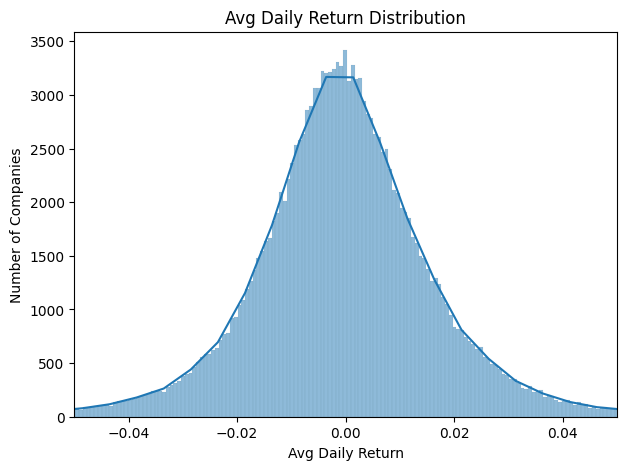

In [27]:
# Average Daily Return Distribution
plt.figure(figsize=(7,5))
sns.histplot(stock_history_2023['Return'], kde=True)
plt.xlim(-0.05, 0.05)
plt.title('Avg Daily Return Distribution')
plt.xlabel('Avg Daily Return')
plt.ylabel('Number of Companies')
plt.show()

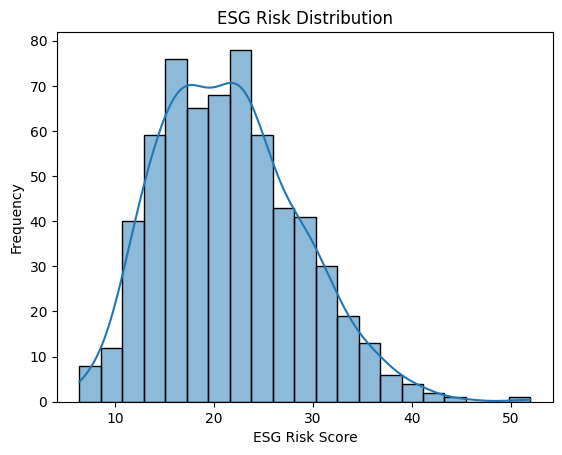

In [26]:
# ESG Risk Distribution
plt.figure()
sns.histplot(esg_proj_2024_data['Total_ESG'], kde=True)
plt.title('ESG Risk Distribution')
plt.xlabel('ESG Risk Score')
plt.ylabel('Frequency')
plt.show()

# Combining Return and ESG Risk

In [30]:
# Avg Return vs Avg Total ESG Risk
plt.figure(figsize=(6,5))
sns.scatterplot(x='ESG_Risk', y='Return', alpha=0.5)
plt.title('Avg Return vs Avg ESG Risk')
plt.xlabel('Avg Total ESG Risk')
plt.ylabel('Avg Daily Return')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

ValueError: Could not interpret value `ESG_Risk` for `x`. Value is a string, but `data` was not passed.

<Figure size 600x500 with 0 Axes>